In [1]:
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodecsv as csv
import seaborn as sns
from cycler import cycler
from textwrap import wrap
from IPython.display import display, HTML, Markdown

# Analysize variables.

In [2]:
# Read documentation.
columns_file = r"../records_documentation.txt"

with open(columns_file,"r") as f:
    columns = f.readlines()
columns
        

['[Column 0] ID\n',
 '[Column 1] Birth year: deduced from education history, where available\n',
 '[Column 2] Gender flag: 1=female, 2=male, 0=unknown\n',
 '[Column 3] Skillset1: primary skillset deduced from self-reported skills\n',
 '[Column 4] Skillset1 weight: the extent to which primary skillset is representative of overall self-reported skills\n',
 '[Column 5] Skillset2: secondary skillset deduced from self-reported skills\n',
 '[Column 6] Skillset2 weight: the extent to which secondary skillset is representative of overall self-reported skills\n',
 '[Column 7] City of profile (does not change): where unavailable, the field is left blank\n',
 '[Column 8] Country of Profile (does not change)\n',
 '[Column 9] Education (highest degree attained): 0=none/unknown; 1=high school; 2=vocational degree; 3=associateÕs; 4=bachelorÕs; 5=masterÕs other than MBA; 6=MBA; 7=doctorate (PhD/JD/MD) [NB: Romanian names not covered]\n',
 "[Column 10] Elite institution: a flag indicating whether any o

So:
- Unique identifier: ID.
- Variable Groups:
    - Column 0-10, profile info; 
    - Column 11-28, employment or education info; (c26 = False or True)
        - Column 11-18, general info;
        - Column 19-25, company info;
        - Column 27-28, school info.

In [3]:
# Get unique values for each variable.
empl_file = r"../deloitte_pwc.csv"

unique_values = []
for i in range(33):
    unique_values.append(set())
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        for i in range(33):
            unique_values[i].add(line[i])
for idx, values in enumerate(unique_values):
    print("[Column {}] ".format(idx)+str(len(values)))
        

[Column 0] 1095185
[Column 1] 84
[Column 2] 3
[Column 3] 45
[Column 4] 390501
[Column 5] 45
[Column 6] 390503
[Column 7] 16127
[Column 8] 258
[Column 9] 8
[Column 10] 2
[Column 11] 849
[Column 12] 3
[Column 13] 763
[Column 14] 3
[Column 15] 2
[Column 16] 3246
[Column 17] 2640332
[Column 18] 865
[Column 19] 1767657
[Column 20] 1557541
[Column 21] 10261
[Column 22] 309
[Column 23] 2
[Column 24] 204454
[Column 25] 739
[Column 26] 2
[Column 27] 8
[Column 28] 2
[Column 29] 1469
[Column 30] 68
[Column 31] 7835
[Column 32] 1003970


In [4]:
# One block to convert data to pd.DataFrame.
empl_file = r"../deloitte_pwc.csv"

entries_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, line in enumerate(reader):
        if idx == 20: # Control number of rows.
            break
        entries_lst.append(line)

samples_lst = entries_lst
entries_df = pd.DataFrame(data=entries_lst)
entries_df.loc[lambda df:df[26]=='False',[17,18]]


17          18
2   Financial Controller Assistant,financial contr...  ACCOUNTING
3                       Junior Auditor,junior,auditor            
4                         Audit Manager,audit,manager  ACCOUNTING
5                   Internal Auditor,internal auditor            
6                     Deputy Director,deputy director   OVERSIGHT
7                                                   -            
8                                                   -            
9                                                   -            
11  Project Management Intern,project management,i...            
12                  Student Employee,student,employee            
16                                      Intern,intern            
17                                      Intern,intern            
18          Associate Consultant,associate consultant            
19                           Treasury Analyst,analyst  ACCOUNTING

In [5]:
# Get an example.
entry = samples_lst[2]
for i in range(len(entry)):
    print("[Column {}] ".format(i)+entry[i])

[Column 0] ed3c50a8-d2d3-3809-9d2a-0f53574560aa
[Column 1] 1980
[Column 2] 2
[Column 3] Accounting and Auditing
[Column 4] 0.9292892909340925
[Column 5] Industrial Management
[Column 6] 0.00825650305491638
[Column 7] Paris
[Column 8] France
[Column 9] 5
[Column 10] False
[Column 11] 2004-09-01
[Column 12] True
[Column 13] 2005-06-01
[Column 14] True
[Column 15] False
[Column 16] 273
[Column 17] Financial Controller Assistant,financial controller,assistant
[Column 18] ACCOUNTING
[Column 19] EADS Astrium
[Column 20] EADS Astrium
[Column 21] 
[Column 22] 
[Column 23] False
[Column 24] 
[Column 25] 
[Column 26] False
[Column 27] 
[Column 28] False
[Column 29] 
[Column 30] 
[Column 31] 
[Column 32] 1525765406000


# Aggregate employment changes to the firm-by-date level.

In [6]:
# Read, Identify & Aggregate. - A code to output raw data for reference. Unfinished and unused.
empl_file = r"../deloitte_pwc.csv"

## Initialize.
career_lst = [] # Will contain the entries for the same person.
person_this = None
profile_this = None

## Iterate.
empl_changes_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, entry in enumerate(itertools.chain(reader,[None]*33)):
        if idx == 100: # End point.
            break
        if person_this != entry[0]:
            if career_lst != []:
                ### Analyze.
                career_df = pd.DataFrame(career_lst)
                print(career_df[[0,1,2,3,4,10,14]])
                print(profile_this)
                ####################################################################
                # empl_changes_lst.append()
            ### Re-initialize.
            person_this = entry[0]
            profile_this = entry[1:11]
            career_lst = []
        ### Record this entry.
        if profile_this[2] == 'Accounting and Auditing' and entry[26] == 'False': # only consider accountants.
            career_lst.append(entry[11:29])

#####################################################
# empl_changes_df = pd.DataFrame(empl_changes_lst)
            

           0      1           2      3      4  10  14
0  2004-09-01   True  2005-06-01   True  False       
1  2006-07-01   True  2006-11-01   True  False  P  54
2  2007-01-01   True  2012-10-01   True  False  P  54
3  2012-10-01   True  2016-07-01   True  False     48
4  2017-01-01  False        None  False   True     92
['1980', '2', 'Accounting and Auditing', '0.9292892909340925', 'Industrial Management', '0.00825650305491638', 'Paris', 'France', '5', 'False']
           0      1           2      3      4         10        14
0  2001-01-01  False  2001-12-01  False  False  TIME_OFF  TIME_OFF
1  2002-09-01   True  2003-02-01   True  False         D       561
2  2003-02-01   True  2004-07-01   True  False         D       561
3  2004-09-01   True  2005-02-01   True  False         D       561
4  2005-09-01   True  2008-09-01   True  False         D       561
5  2008-08-01   True  2013-07-01   True  False         D       561
6  2013-07-01   True  2016-11-01   True  False                 

Definition of employment change types: When only employment records are considered, an employment change will be recognized as
- `hiring` if it changed its company to one of the two companies (Deloitte and PwC, hereafter);
- `firing` if it changed its company from one of the two companies to `TIME_OFF` and stayed in `TIME_OFF` for more than 100 days;
- `leaving` if it changed its company from one of the two companies and not recogized as `firing`.

In [7]:
# Define a class to read and process entries.
class entryProcessor:    
    
    def __init__(self, person_id):
        self.person_id = person_id
        self.profile = [None]*6 # "birth_year","gender","secondary_skill","country","education_level","f_elite"
        self.employment = [None]*7 # "start_date","end_date","ticker","f_current","job_role","department", "nth_posit"
        
    # Three functions to output records.
    # Varlist: Hiring/Leaving/Firing, Ticker, year-month, profile_info: [...], next_industry.
    def enter_record(self):
        return ['hiring',self.employment[2],self.employment[0]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+['',''] 
    def leave_record(self,next_industry):
        return ['leaving',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+[next_industry]+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                                 self.employment[6]]
    def fired_record(self):
        return ['firing',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                      self.employment[6]]
    
    # When id changes, record a possible leave and then clear contents.
    def reinitialize(self,entry):
        if self.employment[3]=="False":
            record = self.leave_record('')
        else:
            record = None
        self.__init__(entry[0])
        self.profile = [entry[x] for x in [1,2,5,8,9,10]]
        if entry[6] is not None:
            self.profile[2] = '' if float(entry[6])<0.1 else entry[5]
        return record
    
    # Main method: read and process.
    def read(self,entry):
        record = []
        # Reinitialize when id changes.
        if self.person_id != entry[0]:
            leave_last = self.reinitialize(entry)
            if leave_last is not None:
                record.append(leave_last)
        # Then deal with the current entry.
        if entry[3]=="Accounting and Auditing" and entry[26] == "False":
            if self.employment[2] != entry[21]:
                if self.employment[2] in ['D','P']:
                    if entry[25] == "TIME_OFF" and int(entry[16]) > 100:
                        record.append(self.fired_record())
                    else:
                        record.append(self.leave_record(entry[25]))
                self.employment = [None]*7
                if entry[21] in ['D','P']:
                    self.employment[0] = entryProcessor.convert_time(entry[11],entry[12])
                    self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                    self.employment[2] = entry[21]
                    self.employment[3] = entry[15]
                    self.employment[4] = entry[17]
                    self.employment[5] = entry[18]
                    self.employment[6] = 0
                    record.append(self.enter_record())
            else:
                self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                self.employment[3] = entry[15]
                self.employment[6] += 1
        return record
            
    # Unbound methods.
    def convert_time(date,f_valid_month):
        date_regex = re.match(r"(\d{4})-(\d{2})-\d{2}",date)
        if date_regex is None:
            return None
            #raise ValueError('Not a proper date: {}'.format(date))
        else:
            return date_regex.group(1)+('00' if f_valid_month == 'False' else date_regex.group(2))
    
    def time_diff(end_date,start_date):
        if end_date is not None and start_date is not None:
            edt, sdt = int(end_date), int(start_date)
            yr_diff = edt//100-sdt//100
            emth = edt%100
            smth = sdt%100
            if not yr_diff and not (emth and smth):
                return min(6,(emth-smth-1)%12+1)
            else:
                return yr_diff*12+(emth if emth else 6)-(smth if smth else 6)
        else:
            return np.nan
        
    # For print.
    def __str__(self):
        return "[person_id: {}, profile: {}, employment: {}]".format(self.person_id, self.profile, self.employment)
            
#entry = entryProcessor(None)
#for i in range(50):
#    print(i)
#    print(entry.read(samples_lst[i]))
#    print(entry)

In [8]:
# Read, Identify & Aggregate.
empl_file = r"../deloitte_pwc.csv"

## Initialize.
career = entryProcessor(None)

## Iterate.
empl_changes_lst = []
with open(empl_file,"rb") as f:
    reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
    for idx, entry in enumerate(itertools.chain(reader,[[None]*33])):
        if idx == np.inf: # End point.
            break
        empl_change_this = career.read(entry)
        if empl_change_this != []:
            empl_changes_lst += empl_change_this

varlist = [
    "type","ticker","yrmth","birth","gender","skill2","cntry","edu","f_elite",
    "job_role","depmt","ind_next","tenure","nprom"
]
empl_changes_df = pd.DataFrame(data=empl_changes_lst,columns=varlist)
empl_changes_df


type ticker   yrmth birth gender                        skill2  \
0        hiring      P  200607  1980      2                                 
1       leaving      P  201210  1980      2                                 
2        hiring      D  200209  1978      2                                 
3       leaving      D  201307  1978      2                                 
4        hiring      D  200708  1983      2  Technical Product Management   
5       leaving      D  200808  1983      2  Technical Product Management   
6        hiring      P  201108  1986      2                                 
7        hiring      P  201405  1985      1            Musical Production   
8       leaving      P  201407  1985      1            Musical Production   
9        hiring      P  201207  1988      0                                 
10      leaving      P  201603  1988      0                                 
11       hiring      P  200008  1974      2             Middle Management   
12      leaving      P  200306  1974      2             Middle Management   
13       hiring      D  201206  1993      2                                 
14      leaving      D  201306  1993      2                                 
15       hiring      D  200910  2000      0                                 
16      leaving      D  201502  2000      0                                 
17       hiring      D  201209  1986      0          Business Development   
18      leaving      D  201404  1986      0          Business Development   
19       hiring      D  201200  1980      2                                 
20      leaving      D  201300  1980      2                                 
21       hiring      P  200801  1979      1                                 
22      leaving      P  201304  1979      1                                 
23       hiring      D  201309  1980      1                                 
24       hiring      P  201406  1989      1                Administration   
25      leaving      P  201408  1989      1                Administration   
26       hiring      P  201710  1989      1                Administration   
27       hiring      D  200912  2000      2                                 
28      leaving      D  201511  2000      2                                 
29       hiring      P  200309  1976      2          Business Development   
...         ...    ...     ...   ...    ...                           ...   
253719  leaving      D  201209  1985      2                                 
253720   hiring      P  201411  1991      2                                 
253721   hiring      D  201207  1985      1                                 
253722   hiring      D  201712  1988      1          Business Development   
253723  leaving      D  201802  1988      1          Business Development   
253724   hiring      D  201410  1982      1                                 
253725   hiring      D  200510  1972      1                                 
253726  leaving      D  201207  1972      1                                 
253727   hiring      D  199502  1976      2                                 
253728  leaving      D  201409  1976      2                                 
253729   hiring      D  201406  1984      1           Banking and Finance   
253730  leaving      D  201603  1984      1           Banking and Finance   
253731   hiring      D  201402  1982      1          Business Development   
253732  leaving      D  201510  1982      1          Business Development   
253733   hiring      D  201605  1982      1          Business Development   
253734   hiring      D  197109  1944      2      Human Resources (Senior)   
253735  leaving      D  197501  1944      2      Human Resources (Senior)   
253736   hiring      D  200902  1987      0      Human Resources (Junior)   
253737  leaving      D  200904  1987      0      Human Resources (Junior)   
253738   hiring      D  200607  1967      2           Banking and Finance   
253739 

# Summarize and plot.

In [9]:
# Styles for the four groups: ('ticker': 'D','P') x ('firing', 'hiring','leaving')
line_styles = ['bo-','b^--','b^-','ro-','r^--','r^-']
color_styles = ['skyblue','b','dodgerblue','mistyrose','r','salmon']

# Styles for the two tickers: ('D', 'P')
color_styles_2 = ['b','r']

In [10]:
# Deal with 'yrmth'.
empl_changes_df = empl_changes_df.assign(
    year = lambda df:df.yrmth.apply(lambda x:int(x[:4]) if x is not None else np.nan),
    month = lambda df:df.yrmth.apply(lambda x:int(x[4:]) if x is not None else -1)
)

empl_changes_df.describe(include=[np.object])

type  ticker   yrmth   birth  gender  skill2          cntry     edu  \
count   253749  253749  247615  253749  253749  253749         253749  253749   
unique       3       2     683      84       3      44            219       8   
top     hiring       P  201109    2000       2          United States       4   
freq    143739  136539    2996   26907  111968  125719          64295  125613   

       f_elite                           job_role   depmt ind_next  tenure  \
count   253749                             253749  253749   253749  250750   
unique       2                              31387     150      538     477   
top      False  Senior Associate,senior associate                            
freq    243230                              11448  146001   190846  143739   

         nprom  
count   253749  
unique      12  
top             
freq    143739

## Count the number of employed accountants from Dec., 1989 on.

Note: 
- This block counts the number of currently employed accountants for the two firms by calculating the cumulative sums of the net employment increase, that is, hiring minus the sum of firing and leaving.
- This method is not effective for the early years. However, if we can assure that we have all the resumes of accountants after some time, we will have the correct number after all the accountants employed before that time have left the company. We assume that the number is correct after 1989 except the most recent years.
- All the numbers are counted in the end of the year and will be used to calculate the proportion of the employment changes for next year. Note that we do not calculate monthly employment separately since there are a good proportion of our data with invalid months.

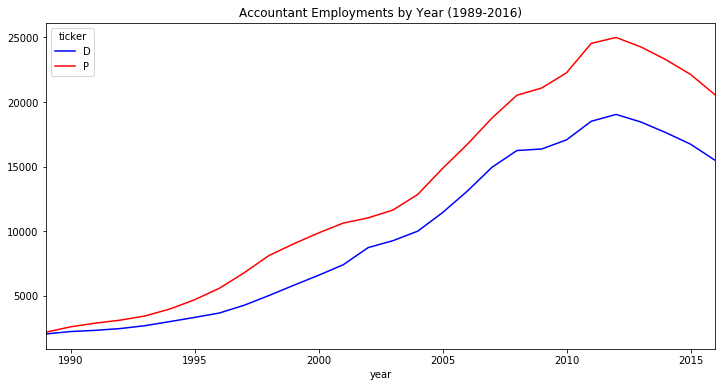

In [11]:
count_by_years = pd.DataFrame({'count':empl_changes_df.groupby(['ticker','type','year']).size()}).reset_index()
empl_by_years = count_by_years.groupby(['ticker','type']).apply(
    lambda df:df.sort_values(['year']).assign(cumsum = lambda df2:df2['count'].cumsum()) # Calculate cumsum.
).reset_index(drop=True).pivot_table(
    index=['ticker','year'],columns='type',values=['cumsum'],fill_value=0 # Reshape to wide format.
).assign(
    employment=lambda df:(df['cumsum']['hiring']-df['cumsum']['firing']-df['cumsum']['leaving']) # Get employment.
).drop('cumsum',axis=1).reset_index()
empl_by_years.columns = empl_by_years.columns.droplevel('type')
empl_by_years.pivot_table(
    index='year',columns='ticker',values='employment'
).loc[lambda df:(df.index>=1989)&(df.index<=2016)].plot(
    figsize=(12,6),color=color_styles_2,title="Accountant Employments by Year (1989-2016)"
)
plt.show()

## Overall trends.
Note: Plots by year and plots by months do not only differ in frequency, but also in sample size. This is due to the entries without valid month record.

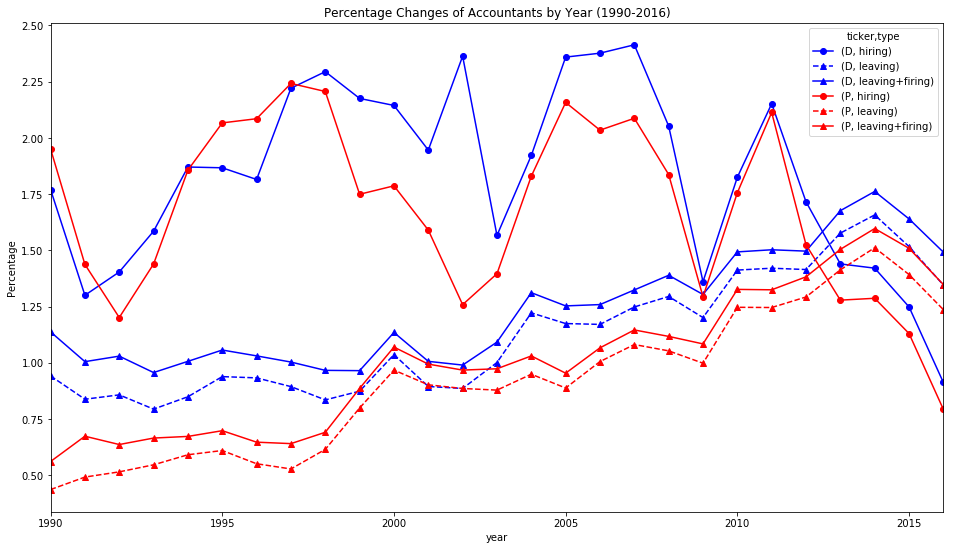

In [12]:
# Count and calculate percentages of employment changes.
prop_by_months = pd.DataFrame(
    {'count':empl_changes_df.groupby(['ticker','type','year','month']).size()} # Count by month.
).reset_index().merge(
    right=empl_by_years.assign(year_1L=lambda df:df.year+1)[['ticker','year_1L','employment']],
    left_on = ['ticker','year'], right_on = ['ticker','year_1L'] # Merge with last year's employment.
).assign(
    prop=lambda df:df['count']/df['employment']*100 # Calculate proportions.
).drop(
    ['count','year_1L','employment'],axis=1 # Drop unnecessary variables.
).loc[lambda df:(df.year>=1990)&(df.year<=2016)] # Keep only [1990, 2016] segment.

# Plot by year.
prop_by_months.pivot_table(
    index = ['ticker','year'], columns = 'type', values = 'prop'
).reset_index().assign(
    **{"leaving+firing":lambda df:(df.leaving+df.firing)}
).pivot_table(
    index='year', columns='ticker', values=['hiring','leaving','leaving+firing']
).reorder_levels(
    ['ticker','type'],axis=1
).sort_index(axis=1).plot(
    style=line_styles, figsize=(16,9), title="Percentage Changes of Accountants by Year (1990-2016)"
).set_ylabel('Percentage')
plt.show()

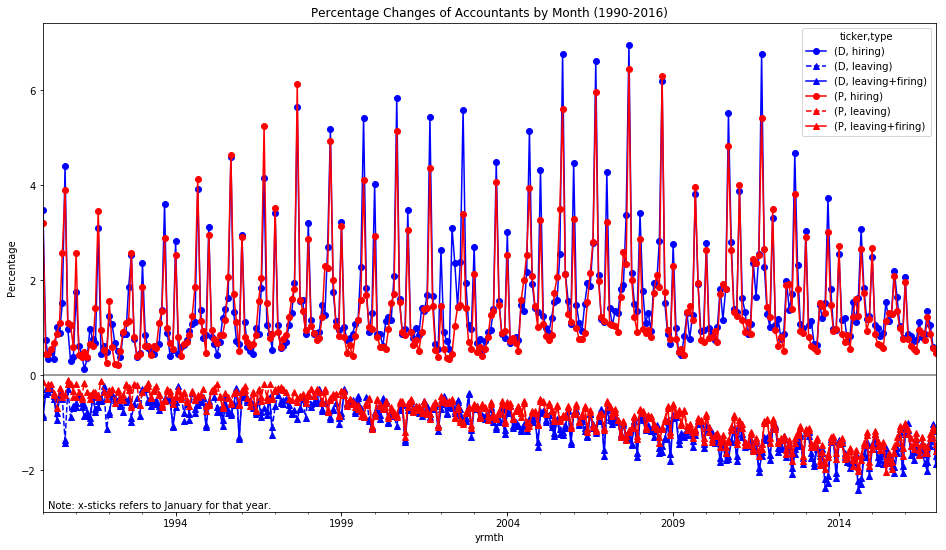

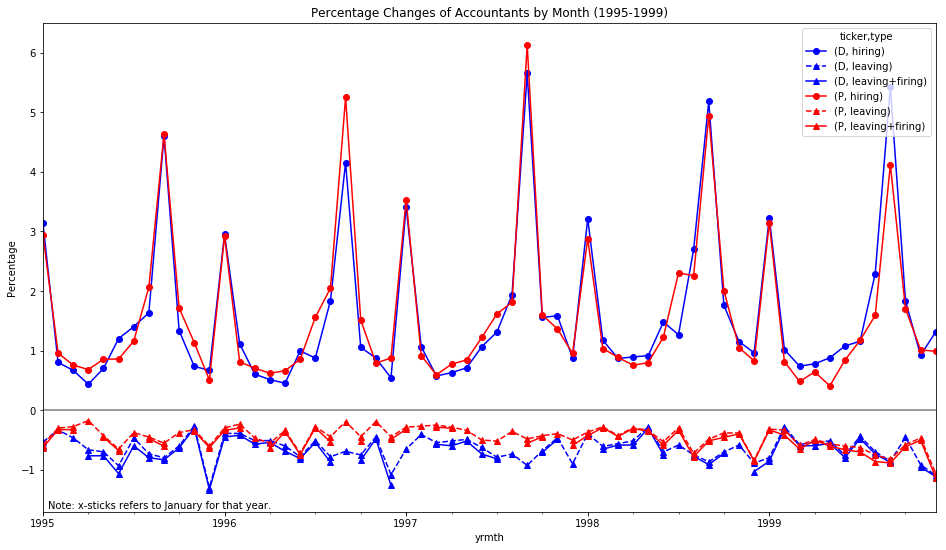

In [13]:
# Plot by month.
## Define a routine for plotting over segments.
def plot_by_month(start_year=1990,end_year=2016):
    prop_by_months.loc[lambda df:(df.month!=0)&(df.year>=start_year)&(df.year<=end_year)].pivot_table(
        index = ['ticker','year','month'], columns='type', values = 'prop'
    ).reset_index().assign(
        **{
            "leaving+firing":lambda df:-(df.leaving+df.firing),
            "leaving":lambda df:-df.leaving,
            "yrmth":lambda df:pd.PeriodIndex(year=df.year,month=df.month,freq='M')
        }
    ).pivot_table(
        index='yrmth', columns='ticker', values=['hiring','leaving','leaving+firing']
    ).reorder_levels(
        ['ticker','type'],axis=1
    ).sort_index(axis=1).plot(
        style=line_styles, figsize=(16,9), 
        title="Percentage Changes of Accountants by Month ({}-{})".format(start_year,end_year)
    ).set_ylabel('Percentage')
    plt.hlines(0,pd.Period('{}-01'.format(start_year)),pd.Period('{}-12'.format(end_year)),colors='tab:gray')
    plt.annotate("Note: x-sticks refers to January for that year.",(5,3),xycoords="axes points")
    plt.show()

    
plot_by_month() # Plot by month over the whole timespan.
plot_by_month(1995,1999) # An example for plotting by month over 1995-1999.

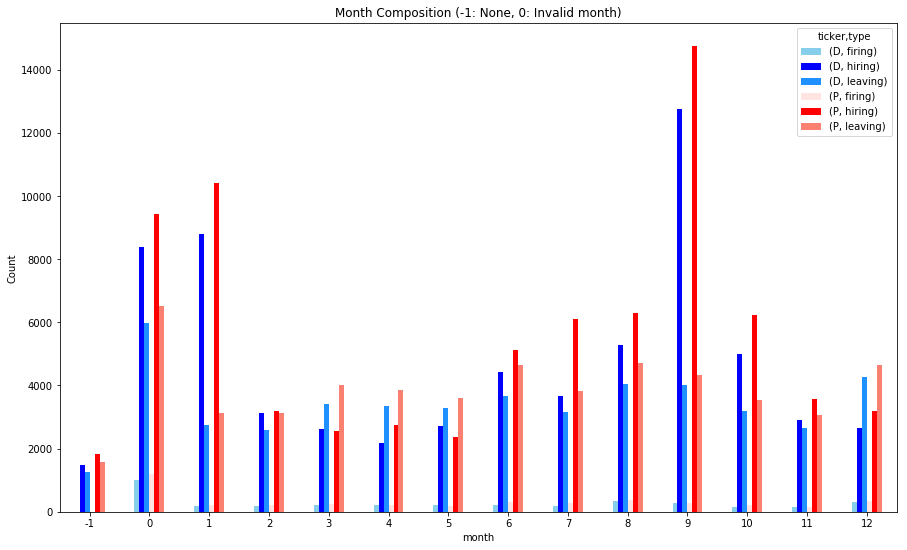

In [14]:
# Month composition.
empl_changes_df.assign(count=1).pivot_table(
    index = 'month', columns = ['ticker','type'], values='count', aggfunc='sum', fill_value=0
).plot.bar(
    figsize=(15,9),color=color_styles,rot=0,
    title="Month Composition (-1: None, 0: Invalid month)"
).set_ylabel("Count")
plt.show()

## By birth group.
Note: Birth year `2000` seems to be a trash bin for problematic records and thus will be treated the same as `None`.

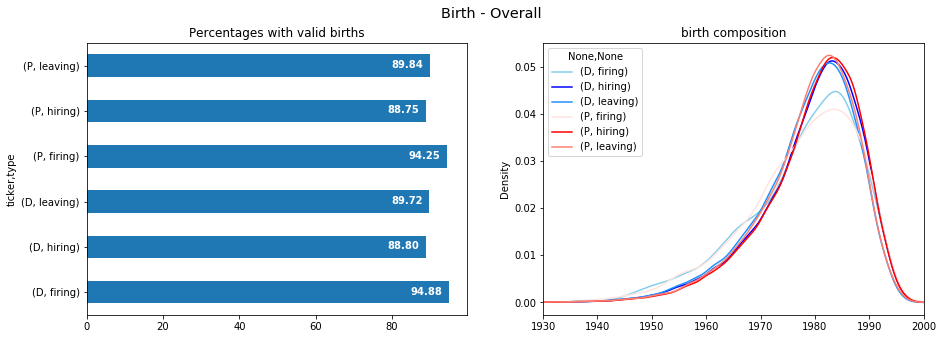

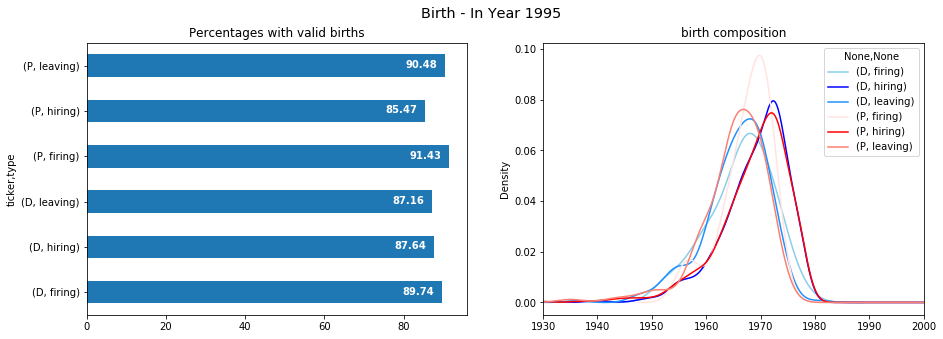

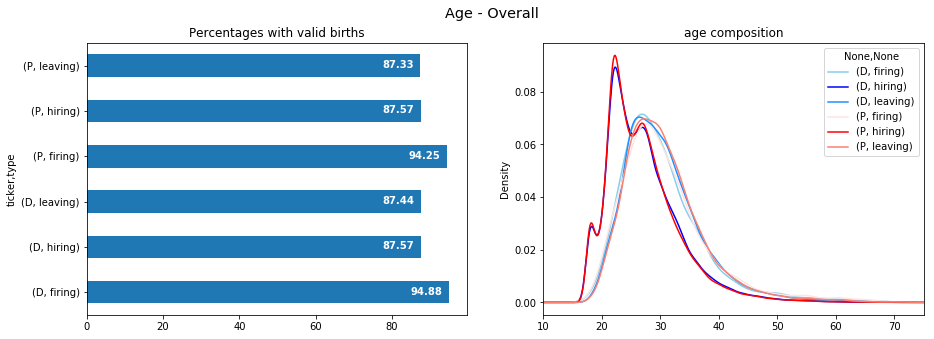

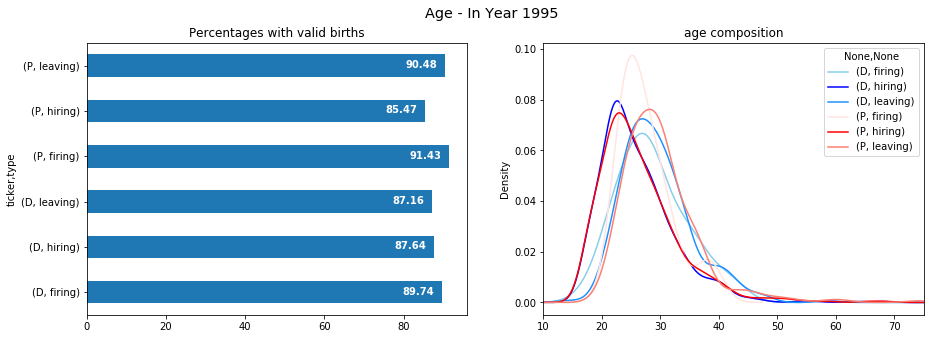

In [15]:
birth_df = empl_changes_df[['ticker','type','year','birth']]
birth_df = birth_df.assign(
    birth = lambda df:df.birth.apply(lambda x:int(x) if x not in ['2000','None'] else np.nan),
    age = lambda df:(df.year-df.birth)
)

# Define a routine to generate plots.
def birth_plot(DF,var,title,xlim=None):
    plt.subplots(1,2,figsize=(15,5))
    plt.suptitle(title,fontsize="x-large")
    plt.subplot(121)
    to_plot = DF.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(DF.loc[~DF[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()
    
birth_plot(birth_df,'birth',"Birth - Overall",(1930,2000))
birth_plot(birth_df.loc[birth_df.year==1995],'birth',"Birth - In Year 1995",(1930,2000))
birth_plot(birth_df,'age',"Age - Overall",(10,75))
birth_plot(birth_df.loc[birth_df.year==1995],'age',"Age - In Year 1995",(10,75))

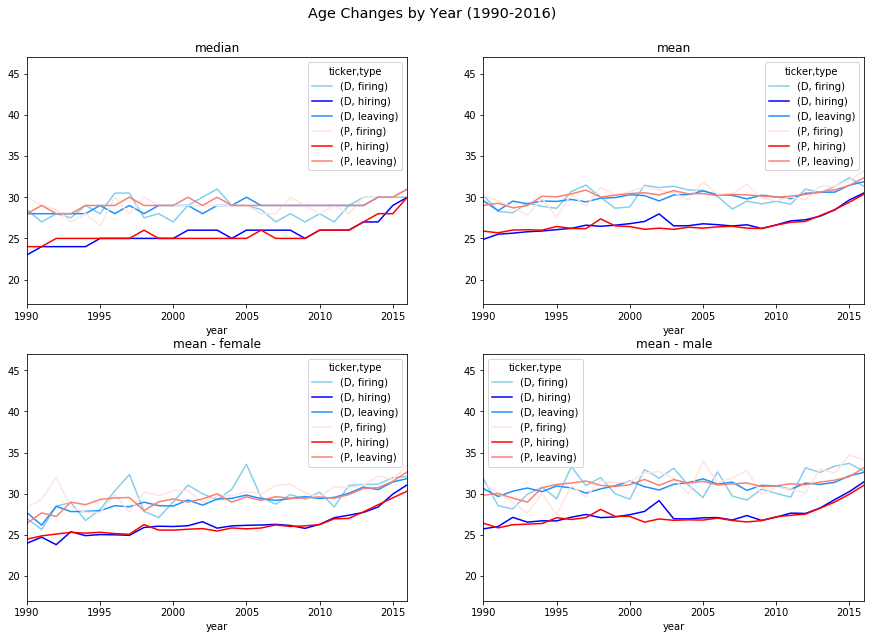

In [16]:
# Age changes by year.
fig, ((ax11, ax12), (ax21, ax22))=plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Age Changes by Year (1990-2016)',fontsize='x-large',y=0.95)
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='median'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax11,title='median')
birth_df.pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax12,title='mean')
birth_df.loc[empl_changes_df.gender=='1'].pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax21,title='mean - female')
birth_df.loc[empl_changes_df.gender=='2'].pivot_table(
    index='year',columns=['ticker','type'],values='age',aggfunc='mean'
).plot(xlim=(1990,2016),ylim=(17,47),color=color_styles,ax=ax22,title='mean - male')
plt.show()

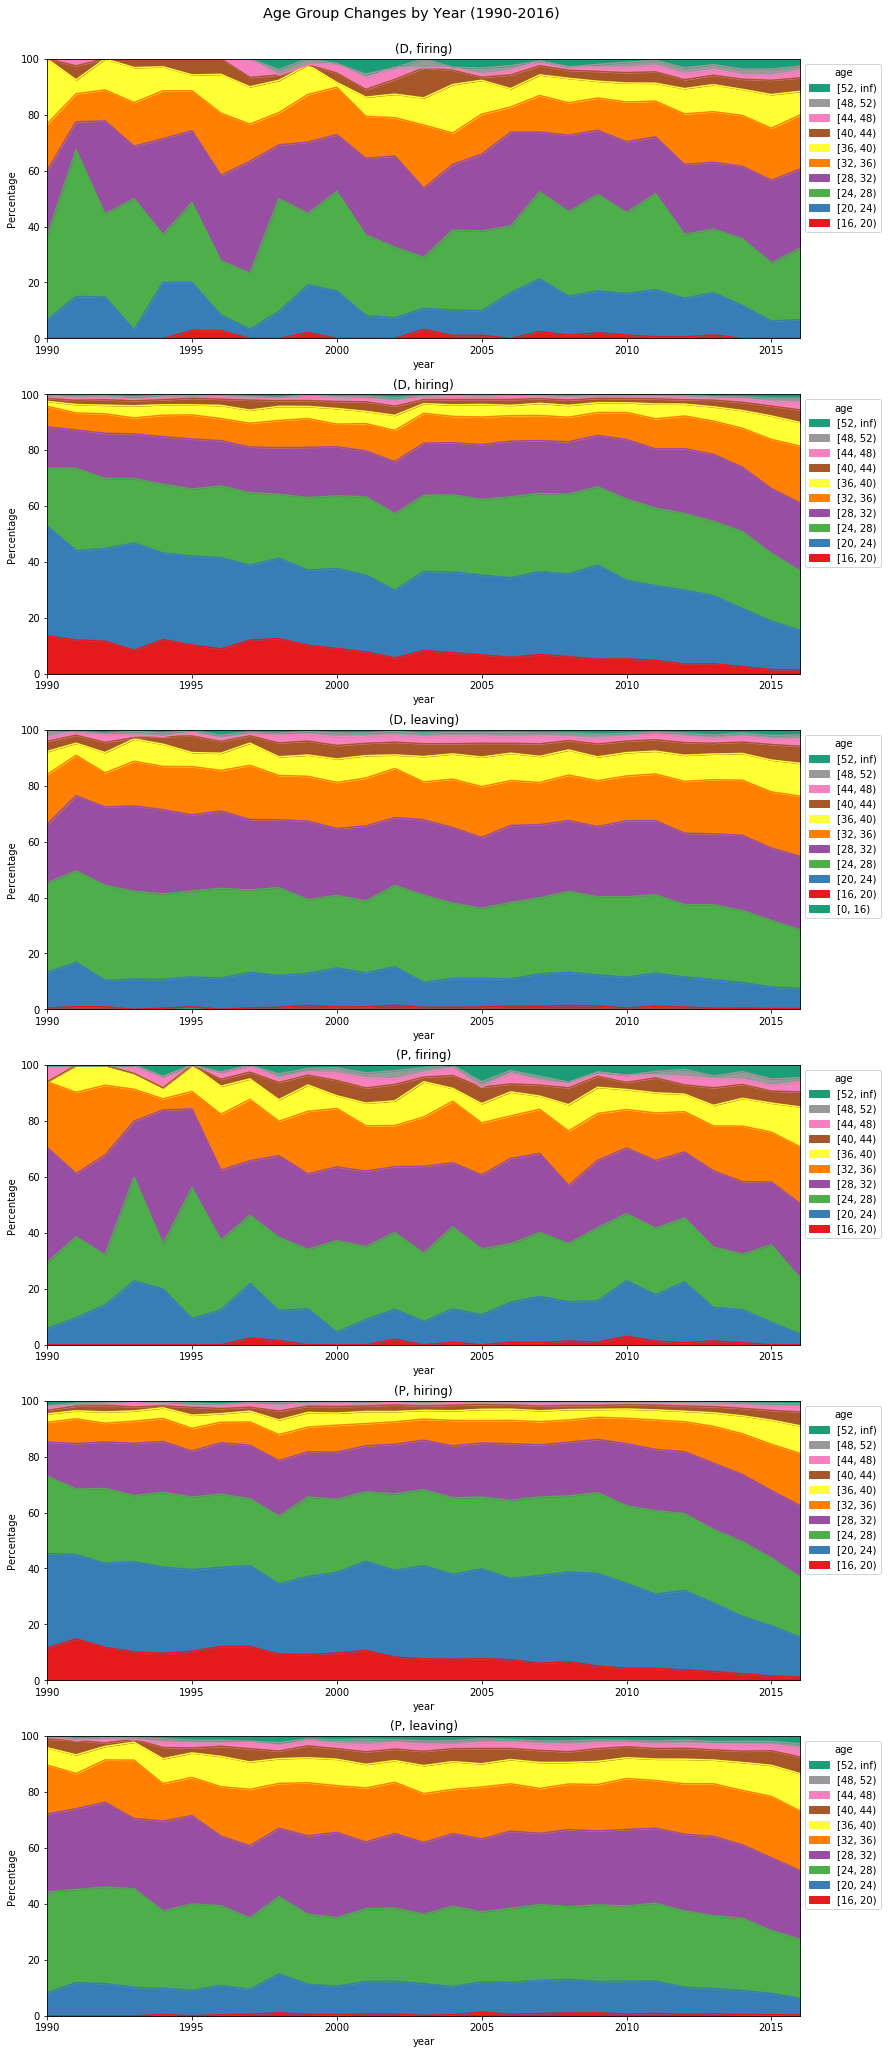

In [17]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Age Group Changes by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=pd.cut(grp.age, bins, right=False, labels=False), values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[colormap_unif[int(float(i))] for i in to_plot.columns]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title='age'
    )
plt.show()

## By Gender.

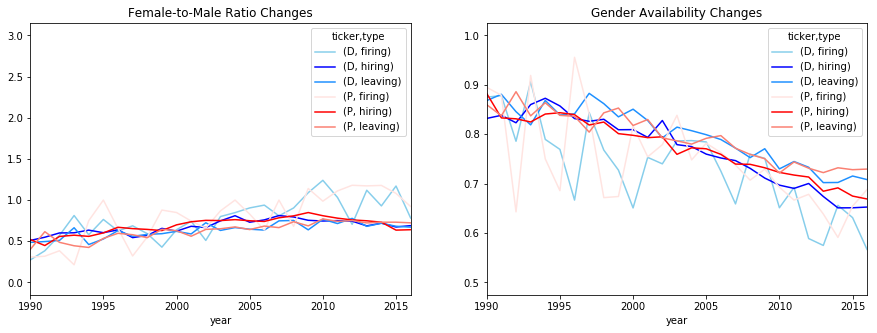

In [18]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x=='1').sum()/(x=='2').sum() if (x=='2').sum() else np.nan)
).plot(xlim=(1990,2016),color=color_styles,title="Female-to-Male Ratio Changes",ax=ax1)
empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='gender',
    aggfunc=lambda x:((x!='0').sum()/x.size)
).plot(xlim=(1990,2016),color=color_styles,title="Gender Availability Changes",ax=ax2)
plt.show()

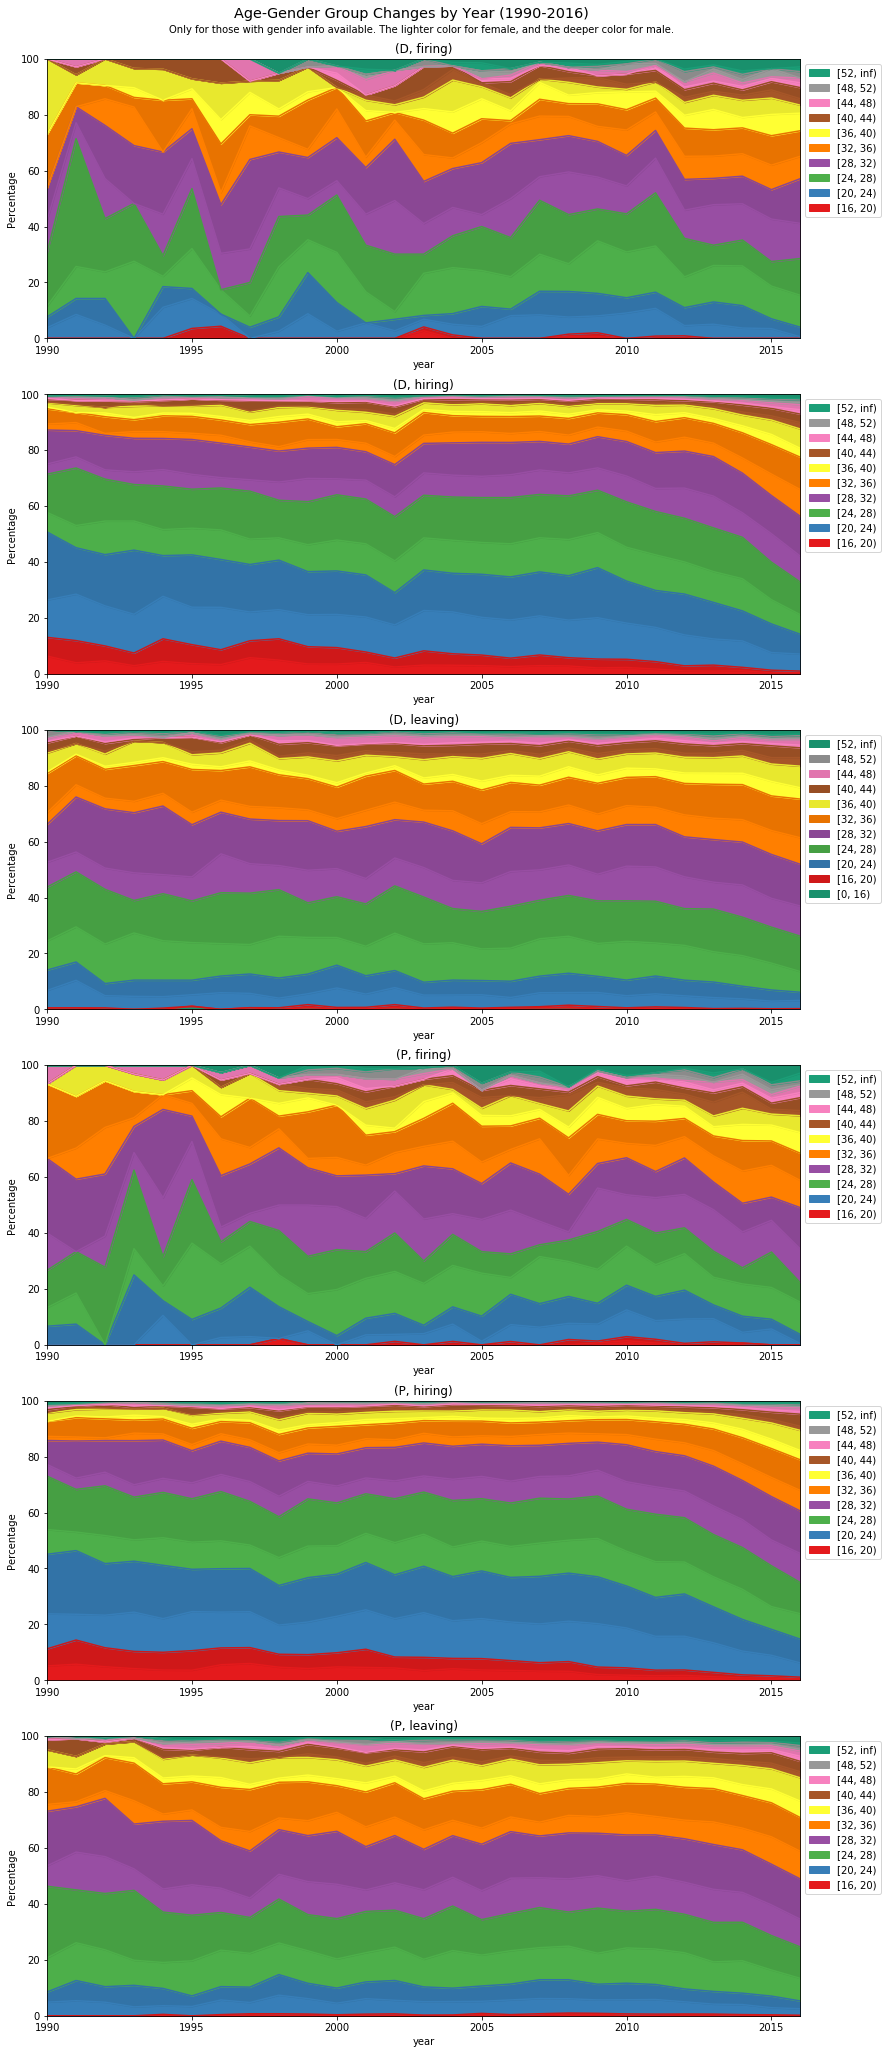

In [19]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Age-Gender Group Changes by Year (1990-2016)", fontsize='x-large', y=0.90)
fig.text(0.25,0.89,
         "Only for those with gender info available. The lighter color for female, and the deeper color for male.")
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(empl_changes_df.gender!='0'), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=[pd.cut(grp.age, bins, right=False, labels=False), empl_changes_df.gender], 
        values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[
            colormap_unif[int(float(i))] if j=='1' else tuple(t/1.1 for t in colormap_unif[int(float(i))]) 
            for i,j in to_plot.columns
        ]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed([handles[i] for i in range(len(handles)) if i%2==0]), 
        reversed(["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in
            [re.match(r"\((\d+)\.0",labels[i]).group(1) for i in range(len(labels)) if i%2==0]
        ]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Secondary Skill.

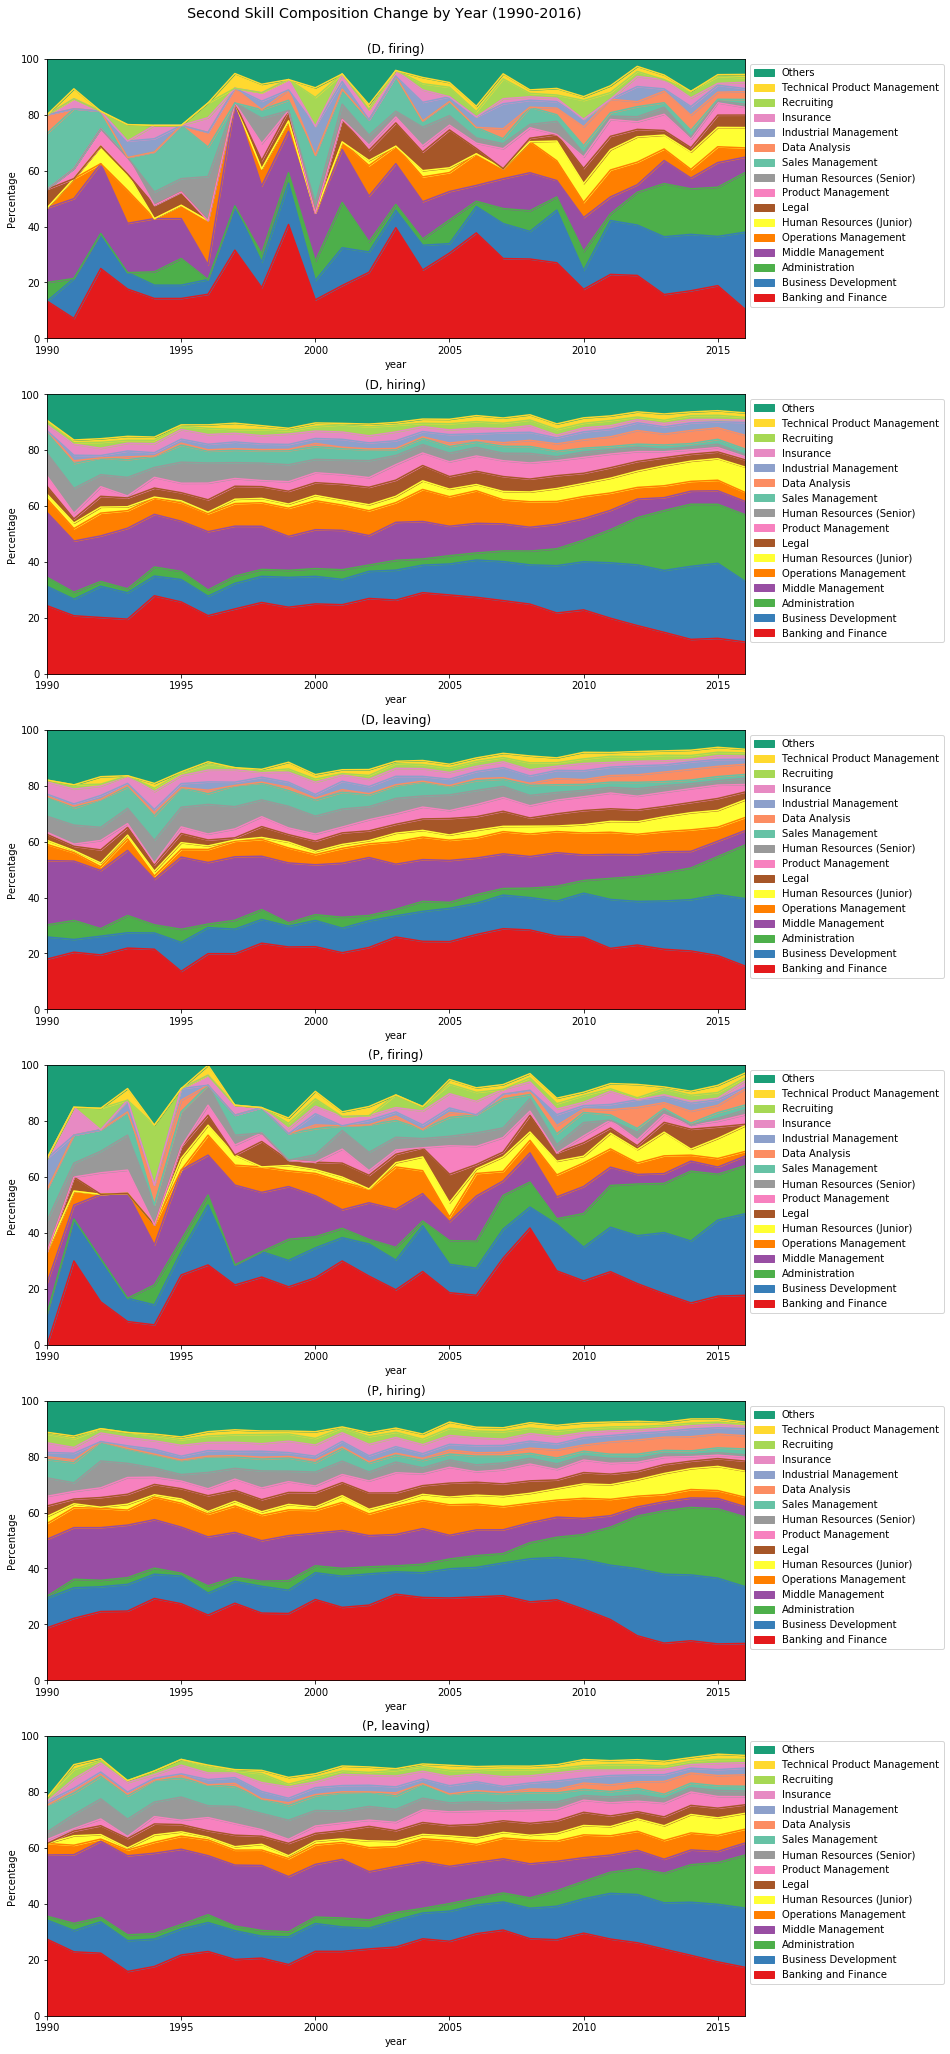

In [20]:
skill2_to_plot = empl_changes_df.loc[lambda df:df.skill2!='']

# Create a uniform colormap for all subplots.
skill2_ord_unif = skill2_to_plot.groupby('skill2').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill2_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     skill2_to_plot.loc[:].pivot_table(
#         index='skill2',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(12.5,36))
fig.suptitle("Second Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    skill2_to_plot.loc[lambda df:df.skill2!=''].loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill2']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        skill2_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill2_ord_unif)}[x] for x in df.skill2
        ], count = 1
    ).pivot_table(
        index='year', columns='skill2_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = skill2_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [21]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill2_ord_unif[i]+"</strong>"))
    to_plot = skill2_to_plot.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill2==skill2_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30).assign(
        job_role=lambda df:df.job_role.apply(lambda x:x.split(",")[0])
    )
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

job_role  prop       depmt   prop                    edu   prop
0            Manager  7.53  Accounting  63.15              Bachelors  46.79
1   Senior Associate  6.66   Oversight  18.02      Masters excl. MBA  23.98
2              Audit  5.44          Hr  11.69           None/Unknown  14.94
3          Associate  4.82    Business   4.24                    MBA  10.30
4            Auditor  4.82   Marketing   0.94  Doctorate (PhD/JD/MD)   2.62
5     Senior Manager  4.23  Operations   0.93            High school   1.00
6             Senior  3.54  Technology   0.64      Vocational degree   0.28
7     Senior Auditor  3.47       Legal   0.34             Associates   0.09
8  Assistant Manager  3.11  Management   0.04                    NaN    NaN
9                  "  2.97  Production   0.02                    NaN    NaN

job_role  \
126557                                   Senior Associate   
170904                                 Assistant Director   
174588                                            Manager   
239130                                  Assistant Manager   
211905                                        Tax advisor   
232184                          Manager Corporate Finance   
4157                                         Audit Senior   
7114                                              Manager   
142796                        Audit Manager - Real Estate   
16055                                             Partner   
143763                                  Assistant Manager   
117360                                      Tax Assistant   
73960                                  Assistant Director   
105112                 Financial Due Diligence Consultant   
152953                          Regional managing partner   
38657                                        Audit Senior   
19688               Asset and Wealth Management Associate   
197818                                     Senior Manager   
53221                                         Tax Advisor   
19283                              Internal Audit Manager   
4483                                            Associate   
6864                                           Consultant   
137696                                            Auditor   
168616                                      Audit Manager   
55239   Manager Enterprise Risk Services - Internal Audit   
240471                         Assistant Manager Taxation   
182183                        Director | Deloitte Private   
5080                       Manager Corporate Finance team   
218673                                  Senior Associates   
94933                                           Associate   

                          depmt                edu f_elite  
126557                                   Bachelors   False  
170904                OVERSIGHT          Bachelors   False  
174588                                         MBA   False  
239130                                None/Unknown   False  
211905               ACCOUNTING  Masters excl. MBA   False  
232184      ACCOUNTING,BUSINESS          Bachelors   False  
4157                 ACCOUNTING          Bachelors   False  
7114                                     Bachelors   False  
142796    OPERATIONS,ACCOUNTING          Bachelors   False  
16055                 OVERSIGHT                MBA    True  
143763                                         MBA   False  
117360               ACCOUNTING          Bachelors   False  
73960                 OVERSIGHT  Masters excl. MBA   False  
105112               ACCOUNTING  Masters excl. MBA   False  
152953                OVERSIGHT          Bachelors   False  
38657                ACCOUNTING          Bachelors   False  
19688                            Masters excl. MBA   False  
197818                                   Bachelors   False  
53221                ACCOUNTING          Bachelors   False  
19283                ACCOUNTING                MBA   False  
4483                                     Bachelors   False  
6864                                     Bachelors   False  
137696                                None/Unknown   False  
168616               ACCOUNTING       None/Unknown   False  
55239   HR,ACCOUNTING,OVERSIGHT          Bachelors   False  
240471               ACCOUNTING  Masters excl. MBA   False  
182183                OVERSIGHT       None/Unknown   False  
5080        ACCOUNTING,BUSINESS          Bachelors   False  
218673                                None/Unknown   False  
94933                                    Bachelors   False

job_role  prop       depmt   prop                    edu   prop
0           Auditor  6.25  Accounting  79.92              Bachelors  44.06
1         Associate  5.56          Hr   7.14      Masters excl. MBA  29.70
2             Audit  5.50   Oversight   5.08           None/Unknown  12.95
3            Intern  4.33    Business   3.80                    MBA   9.15
4    Senior Auditor  4.18  Technology   1.16            High school   1.83
5            Senior  4.03   Marketing   1.16  Doctorate (PhD/JD/MD)   1.54
6  Senior Associate  3.70  Operations   1.12      Vocational degree   0.62
7           Manager  2.90       Legal   0.54             Associates   0.14
8               Tax  2.41  Management   0.04                    NaN    NaN
9    Tax Consultant  1.98  Production   0.03                    NaN    NaN

job_role       depmt                edu f_elite
41418                           Auditor                   None/Unknown   False
240201                        Associate                      Bachelors    True
155688  Assurance Experienced Associate                      Bachelors   False
38550                            Intern                      Bachelors   False
218955                  Auditeur Senior              Masters excl. MBA   False
46237            Consultora em Tributos                      Bachelors   False
105489                    Audit Trainee  ACCOUNTING  Masters excl. MBA   False
105702             Premier vérificateur              Masters excl. MBA   False
97793        Superviseur FS - Insurance  ACCOUNTING        High school   False
244769            Expert Conseil Senior              Masters excl. MBA   False
46673            Fiscal & Tax Assistant  ACCOUNTING          Bachelors   False
151971        Recruitment Administrator          HR          Bachelors   False
179106  Assurance Experienced Associate                      Bachelors   False
36013                      Audit Intern  ACCOUNTING       None/Unknown   False
106890                     Bank auditor  ACCOUNTING  Masters excl. MBA   False
41207                            Intern                    High school   False
201088         Senior Financial Auditor  ACCOUNTING  Masters excl. MBA   False
167798       Senior Associate Assurance              Masters excl. MBA   False
142558                     Audit intern  ACCOUNTING  Masters excl. MBA   False
71370             Consultant - Advisory                      Bachelors   False
182739                Senior Accountant              Masters excl. MBA   False
216484                 Senior Associare                      Bachelors   False
88725                             stage                      Bachelors   False
37047                    External Audit  ACCOUNTING                MBA   False
52133                        L1 Analyst                      Bachelors   False
120378                Assistant Manager                      Bachelors   False
41277        Consultant Project Manager              Vocational degree   False
83587                           Analyst                      Bachelors   False
122453              Articleship Trainee                      Bachelors   False
45853                         Associate                   None/Unknown   False

job_role  prop       depmt   prop                    edu   prop
0            Intern  9.41  Accounting  79.51              Bachelors  56.19
1         Associate  9.35          Hr   7.51      Masters excl. MBA  26.14
2             Audit  6.21   Oversight   5.90           None/Unknown   9.27
3  Senior Associate  4.86    Business   2.81                    MBA   5.06
4               Tax  3.71  Technology   1.31            High school   1.49
5           Auditor  3.08   Marketing   1.25  Doctorate (PhD/JD/MD)   1.19
6            Senior  2.94  Operations   1.14      Vocational degree   0.39
7  Assurance Intern  1.96       Legal   0.49             Associates   0.26
8    Tax Consultant  1.93  Production   0.05                    NaN    NaN
9        Consultant  1.77  Management   0.01                    NaN    NaN

job_role  \
13622                                         Audit Clerk   
127049                                   Assurance Intern   
215008                                     Senior Auditor   
106766                                  Summer Internship   
193098                                             Senior   
111120                           External Audit Assistant   
95050                                 Executive Assistant   
191863  Transfer Pricing & International Tax Advisory ...   
160536                                   Senior Associate   
4766                                           Internship   
226588                                   Senior Associate   
54979                                          Consultant   
56405                         Senior Associate/ Associate   
117503                                   Assurance Intern   
224129                                       Audit Intern   
245657                              Intern Risk Assurance   
80480           Experienced Associate-Audit and Assurance   
5054                                              Manager   
178595               Risk Assurance Experienced Associate   
31733                       Assurance and Advisory Intern   
137972                           Associate External Audit   
7151                                         Audit Intern   
138132                               Assistant Consultant   
56658                                          Consultant   
93478                            Core Assurance Associate   
111069                                    Audit Assistant   
178221                                Semi Senior Auditor   
6592                                      Audit Associate   
105661                             Staff Associate/Intern   
59913                                          Internship   

                      depmt                edu f_elite  
13622            ACCOUNTING          Bachelors   False  
127049                               Bachelors   False  
215008                       Masters excl. MBA   False  
106766                       Masters excl. MBA   False  
193098                               Bachelors   False  
111120           ACCOUNTING  Masters excl. MBA   False  
95050                              High school   False  
191863  ACCOUNTING,BUSINESS          Bachelors   False  
160536                               Bachelors   False  
4766                                 Bachelors   False  
226588                               Bachelors   False  
54979                        Masters excl. MBA   False  
56405                        Masters excl. MBA   False  
117503                       Masters excl. MBA   False  
224129           ACCOUNTING                MBA    True  
245657            OVERSIGHT  Masters excl. MBA    True  
80480                                Bachelors   False  
5054                                 Bachelors   False  
178595            OVERSIGHT          Bachelors   False  
31733                        Masters excl. MBA   False  
137972           ACCOUNTING                MBA   False  
7151             ACCOUNTING  Masters excl. MBA   False  
138132                               Bachelors   False  
56658                                Bachelors   False  
93478                                Bachelors   False  
111069           ACCOUNTING  Masters excl. MBA   False  
178221                               Bachelors   False  
6592             ACCOUNTING          Bachelors   False  
105661                       Masters excl. MBA   False  
59913                                Bachelors   False

job_role  prop       depmt   prop                    edu   prop
0            Manager  7.46  Accounting  73.12              Bachelors  47.41
1            Auditor  7.00   Oversight  10.55      Masters excl. MBA  18.27
2              Audit  6.43          Hr   8.31                    MBA  15.74
3     Senior Auditor  5.19    Business   3.58           None/Unknown  14.55
4   Senior Associate  4.54  Technology   1.41  Doctorate (PhD/JD/MD)   2.20
5             Senior  3.59  Operations   1.30            High school   1.17
6     Senior Manager  3.33   Marketing   1.02      Vocational degree   0.46
7          Associate  3.22       Legal   0.52             Associates   0.19
8  Senior Consultant  2.99  Production   0.12                    NaN    NaN
9         Consultant  2.82  Management   0.06                    NaN    NaN

job_role  \
205930                                            Auditor   
183540                                            Analyst   
67174                                     Audit Associate   
147104                                 Trainee Accountant   
246708  Assistant Manager - Assurance CIPS TICE (last ...   
251154                                         accountant   
143905                                          Associate   
181660                                       Audit Senior   
180226                                     Senior Auditor   
150173   Senior Advisor - Center for Corporate Governance   
193888                                       Audit Senior   
219776        Senior Associate - Financial Due Dilligence   
7879                                    SENIOR CONSULTANT   
168280                                  Senior Consultant   
110803                                  Finance Assistant   
61616          Senior Consultant Global Employer Services   
62581                                   Serior Consultant   
222170                                      Manager Audit   
114794                                   External Auditor   
233796                                              Audit   
177695                                Assurance Associate   
56941             Article Clerk promoted to Audit Manager   
253279                                         Consultant   
92475                                       Audit Manager   
111928                                     Senior Auditor   
94971                                      Senior Auditor   
213322                                      Audit Manager   
77845                                    Senior Associate   
54375                                Accountant (Auditor)   
198819                                  Senior Consultant   

                      depmt                    edu f_elite  
205930                                None/Unknown   False  
183540                                   Bachelors   False  
67174            ACCOUNTING      Masters excl. MBA   False  
147104                                None/Unknown   False  
246708                                   Bachelors   False  
251154                                   Bachelors   False  
143905                                   Bachelors   False  
181660           ACCOUNTING              Bachelors   False  
180226                                   Bachelors   False  
150173  OPERATIONS,BUSINESS                    MBA   False  
193888           ACCOUNTING      Masters excl. MBA   False  
219776           ACCOUNTING      Masters excl. MBA   False  
7879                             Masters excl. MBA   False  
168280                                   Bachelors    True  
110803           ACCOUNTING      Masters excl. MBA   False  
61616                    HR              Bachelors    True  
62581                                 None/Unknown   False  
222170           ACCOUNTING                    MBA    True  
114794                                         MBA   False  
233796           ACCOUNTING              Bachelors   False  
177695                                         MBA    True  
56941            ACCOUNTING  Doctorate (PhD/JD/MD)   False  
253279                                         MBA   False  
92475            ACCOUNTING                    MBA   False  
111928                                   Bachelors   False  
94971                                          MBA    True  
213322           ACCOUNTING           None/Unknown   False  
77845                            Masters excl. MBA   False  
54375                                    Bachelors   False  
198819                                         MBA   False

job_role  prop       depmt   prop                    edu   prop
0            Manager  9.98   Oversight  37.52              Bachelors  45.22
1     Senior Manager  6.39  Accounting  34.09           None/Unknown  20.87
2  Senior Consultant  6.27  Technology  10.97      Masters excl. MBA  20.37
3         Consultant  6.19          Hr   9.83                    MBA   9.85
4            Auditor  3.35    Business   4.12  Doctorate (PhD/JD/MD)   1.89
5   Senior Associate  3.35  Operations   2.11            High school   1.09
6                  "  3.26   Marketing   1.02      Vocational degree   0.66
7              Audit  3.20       Legal   0.32             Associates   0.05
8           Director  3.01  Management   0.01                    NaN    NaN
9  Assistant Manager  2.96         NaN    NaN                    NaN    NaN

job_role  \
71689                                          Consultant   
238396                                IT Audit Specialist   
95211                                   Senior Specialist   
113323                                  Senior Consultant   
114148                          Senior/Manager Consultant   
36942                                             Partner   
18365   Senior ICT Systems and Processes Assurance Spe...   
237961                                     Senior Manager   
214699  Senior Consultant and Consultant - Enterprise ...   
155215    Student Assistant Assurance Industrial Services   
240829                                            Manager   
11355   Associate & Senior Associate External Financia...   
195588                                     Senior Auditor   
35909   Experienced Senior Associate Systems & Process...   
32057                                      Senior Manager   
27789                                   Senior Consultant   
194649                                     senior manager   
131336               Experienced Associate Risk Assurance   
125820                    Senior Associate Risk Assurance   
100831     Senior Manager Financial Services Industry Tax   
225154     Senior Associate Systems and Process Assurance   
32432                                   Senior Consultant   
37857                                      Senior Manager   
120967                                          Principal   
181682                              IT Advisory Associate   
191138                                     Senior Manager   
168949                                     Senior Auditor   
96156                   Senior Associate - Risk Assurance   
22172                                          Treuhänder   
241578                        Assurance Assistant Manager   

                        depmt                edu f_elite  
71689                               None/Unknown   False  
238396  ACCOUNTING,TECHNOLOGY          Bachelors   False  
95211                                  Bachelors   False  
113323                              None/Unknown   False  
114148                                       MBA    True  
36942               OVERSIGHT          Bachelors   False  
18365              TECHNOLOGY                MBA   False  
237961                         Masters excl. MBA   False  
214699           HR,OVERSIGHT          Bachelors   False  
155215                     HR  Masters excl. MBA   False  
240829                                 Bachelors   False  
11355           HR,ACCOUNTING          Bachelors   False  
195588                              None/Unknown   False  
35909              TECHNOLOGY          Bachelors   False  
32057                               None/Unknown   False  
27789                          Masters excl. MBA   False  
194649                                 Bachelors   False  
131336              OVERSIGHT          Bachelors    True  
125820              OVERSIGHT          Bachelors   False  
100831          HR,ACCOUNTING       None/Unknown   False  
225154             TECHNOLOGY          Bachelors   False  
32432                                  Bachelors   False  
37857                                        MBA   False  
120967                                 Bachelors   False  
181682             TECHNOLOGY                MBA   False  
191138                                       MBA   False  
168949                         Masters excl. MBA   False  
96156               OVERSIGHT                MBA   False  
22172                          Masters excl. MBA   False  
241578                                 Bachelors   False

## By Country.

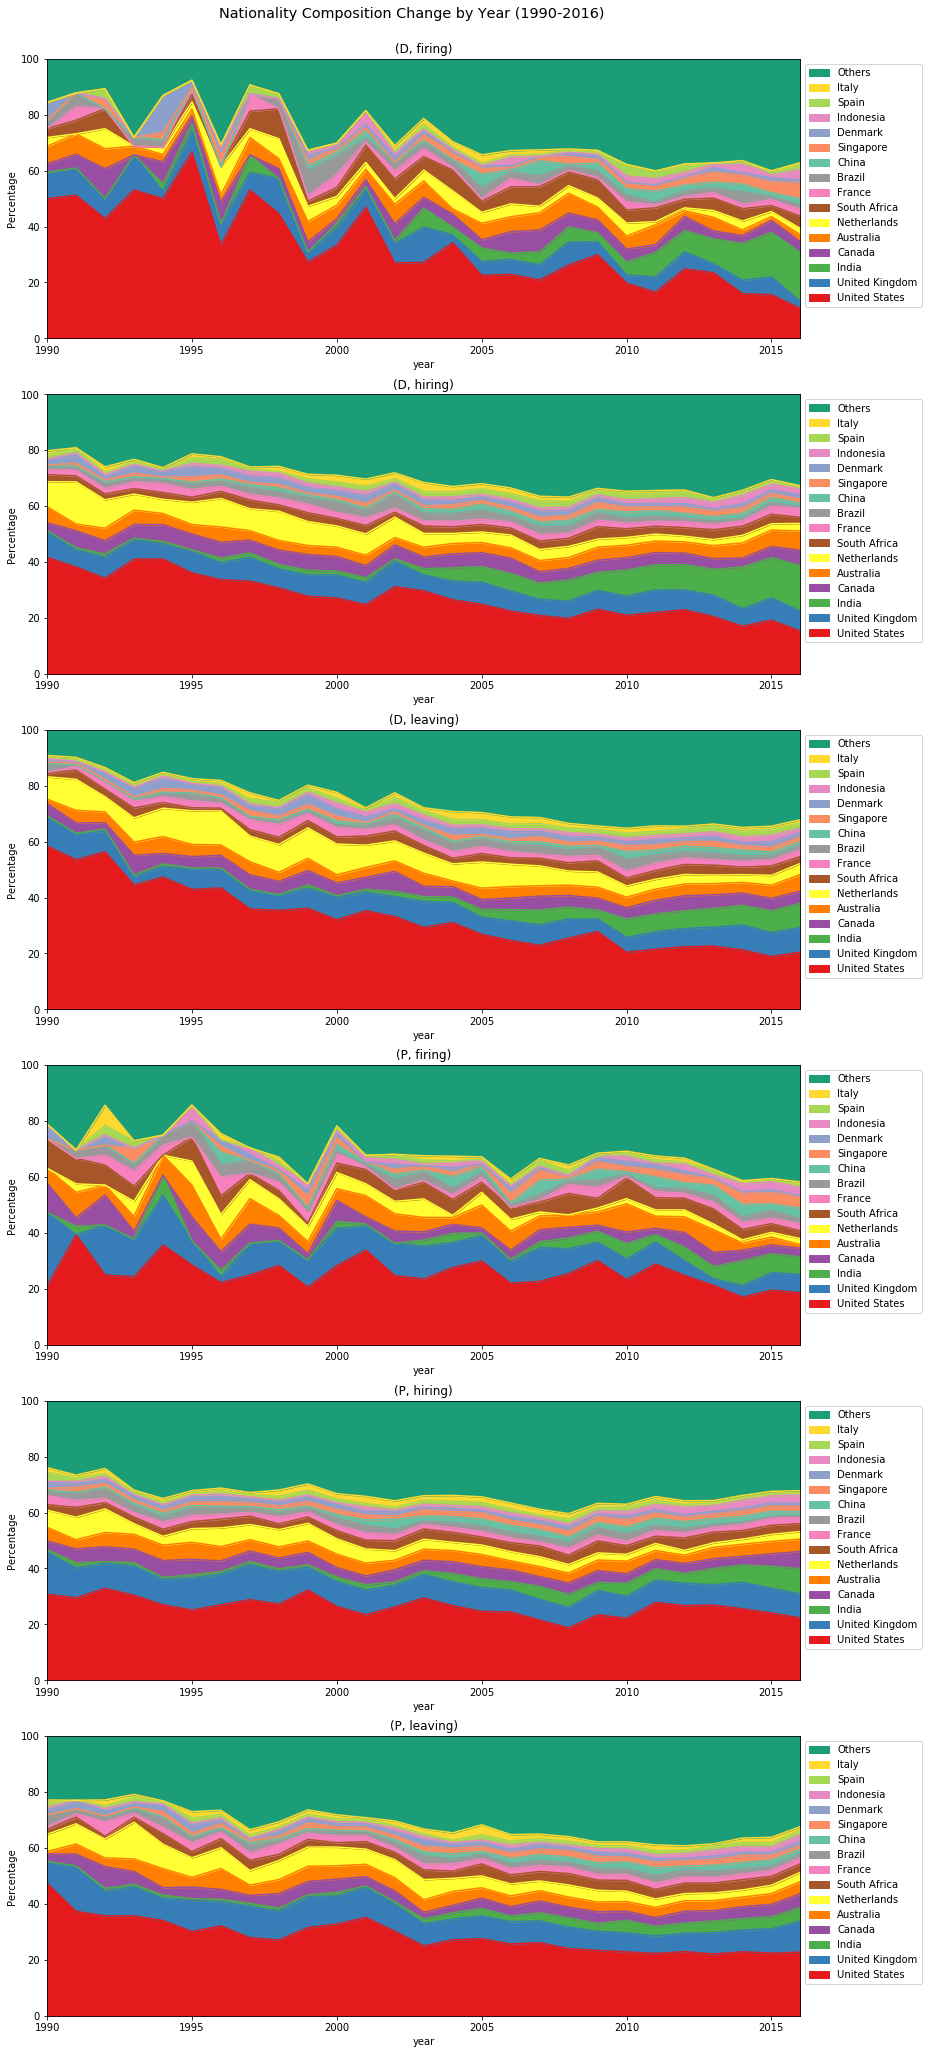

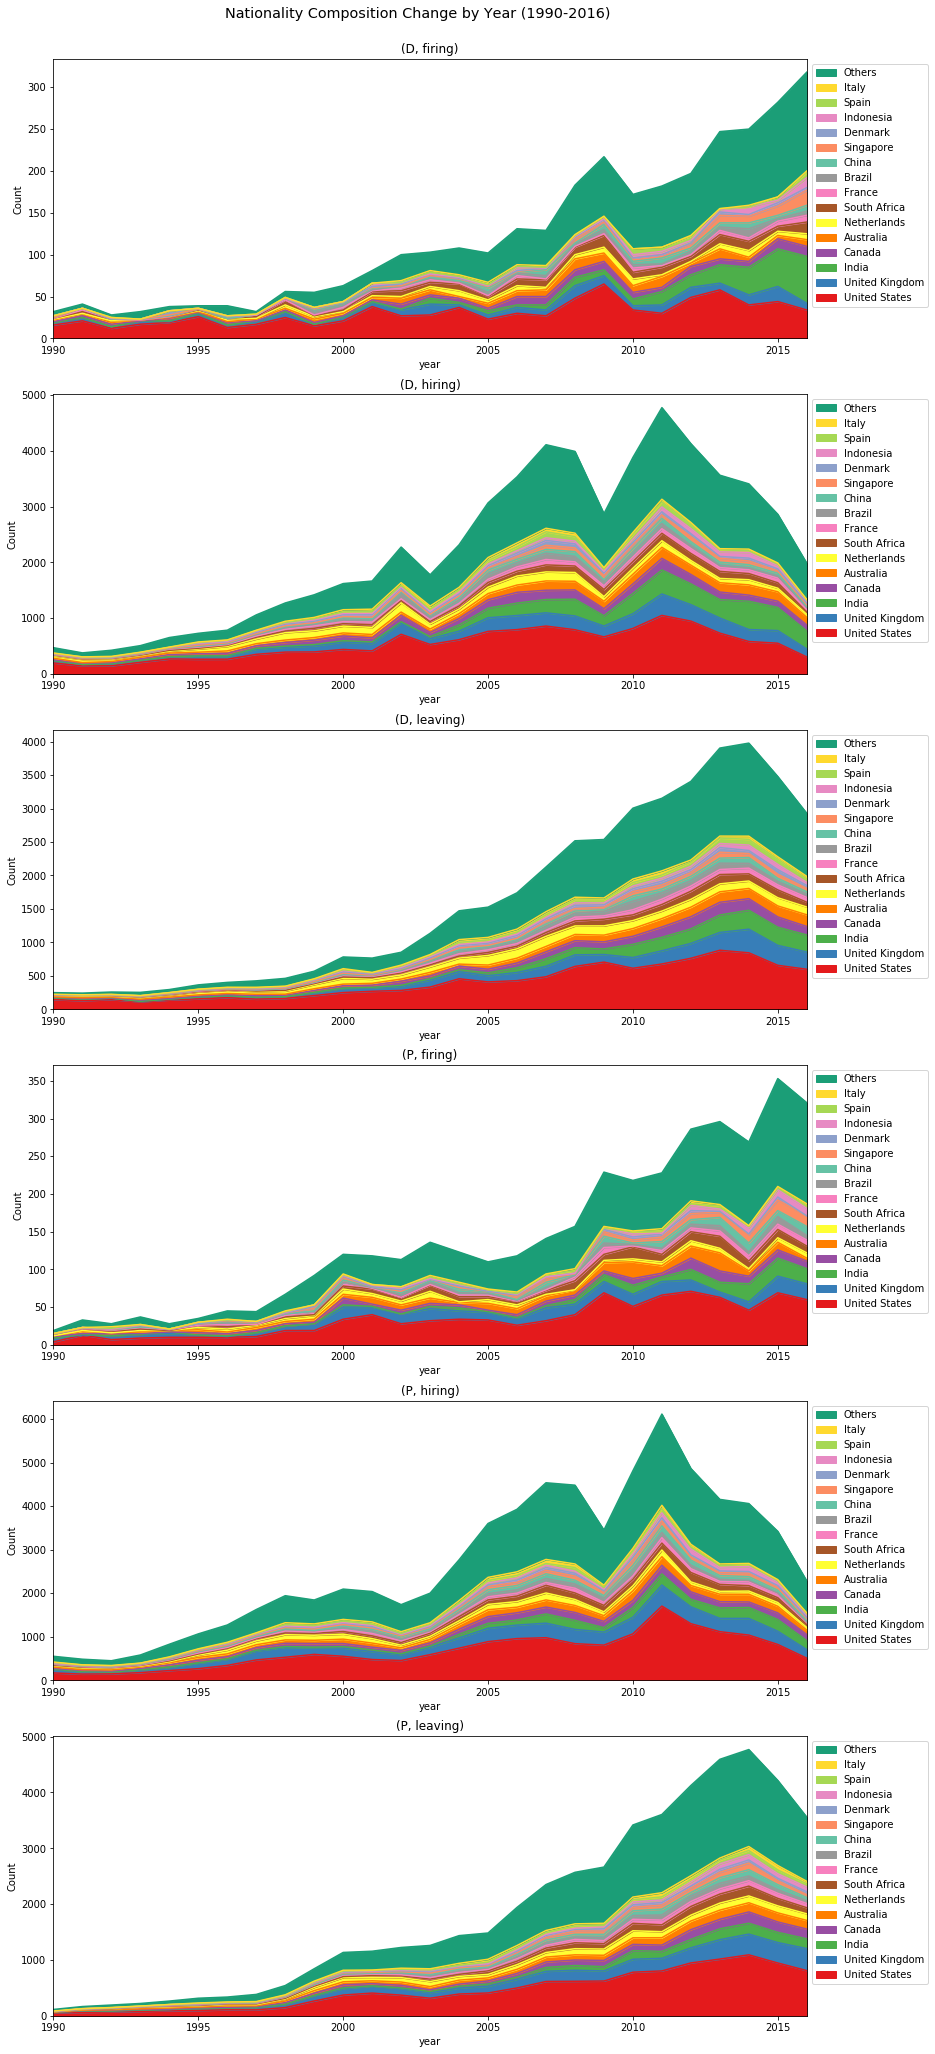

In [22]:
# Create a uniform colormap for all subplots.
cntry_ord_unif = empl_changes_df.groupby('cntry').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    cntry_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='cntry',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:28]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,rotatelabels=True,
#         color = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()


## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = cntry_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0 
    )
    to_plot.columns = cntry_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        title=str(idx).replace("'","")
    )
    ax.set_ylabel("Count")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Education Level.

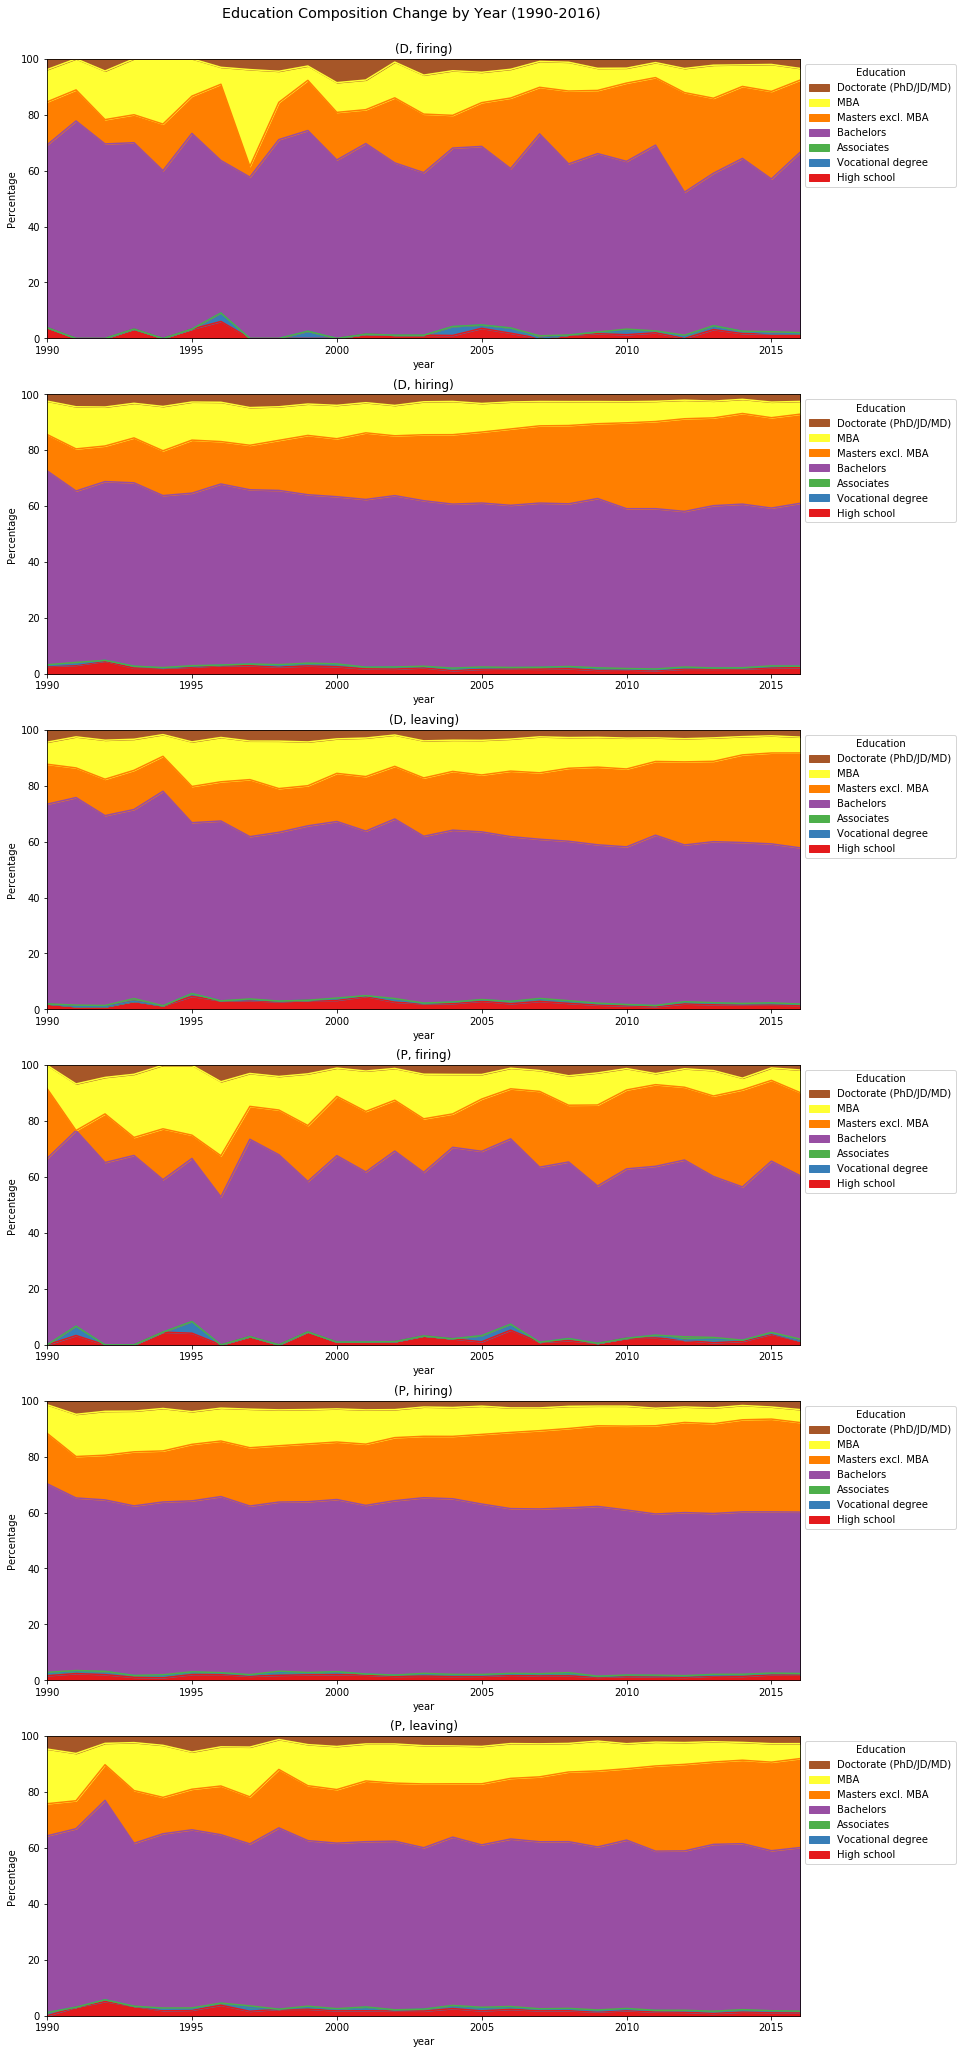

In [23]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}
colormap_unif = {str(idx):clr for idx, clr in zip(
    range(len(edu_lablst)),
    itertools.cycle([plt.get_cmap('Dark2').colors[0]]+list(plt.get_cmap('Set1').colors))
)}

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='edu',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[edu_lablst[x] for x in range(0,8)]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(13.5,36))
fig.suptitle("Education Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','edu']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.loc[lambda df:[int(x)>=f_none_hidden for x in df.edu]].assign(count = 1).pivot_table(
        index='year', columns='edu', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), [edu_lablst[int(x)] for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title="Education"
    )
plt.show()



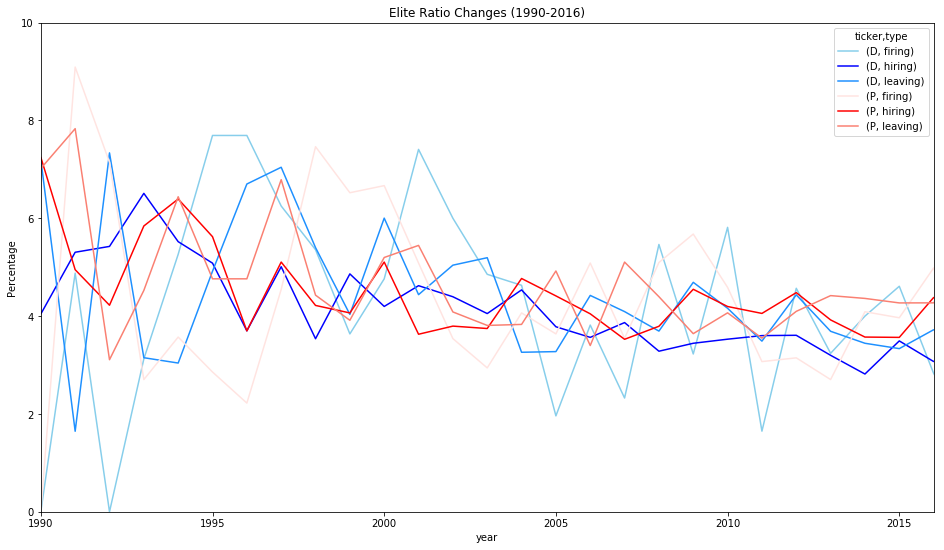

In [24]:
ax = empl_changes_df.pivot_table(
    index='year',columns=['ticker','type'],values='f_elite',
    aggfunc=lambda x:((x=='True').sum()/(x==x).sum()*100)
).plot(
    xlim=(1990,2016),ylim=(0,10),color=color_styles,
    title="Elite Ratio Changes (1990-2016)",figsize=(16,9)
)
ax.set_ylabel('Percentage')
plt.show()

# By Next Industry.

Note: Division of 2-digit NAICS's into industry groups are obtained from [Bureau of Labor Statistics](https://www.bls.gov/iag/tgs/iag_index_naics.htm).

In [25]:
NAICS2GRP_dict = {
    '11': (1, "Natural Resources and Mining"),
    '21': (1, "Natural Resources and Mining"),
    '23': (2, "Construction"),
    '31': (3, "Manufacturing"),
    '32': (3, "Manufacturing"),
    '33': (3, "Manufacturing"),
    '42': (4, "Trade, Transportation, and Utilities"),
    '44': (4, "Trade, Transportation, and Utilities"),
    '45': (4, "Trade, Transportation, and Utilities"),
    '48': (4, "Trade, Transportation, and Utilities"),
    '49': (4, "Trade, Transportation, and Utilities"),
    '22': (4, "Trade, Transportation, and Utilities"),
    '51': (5, "Information"),
    '52': (6, "Financial Activities"),
    '53': (6, "Financial Activities"),
    '54': (7, "Professional and Business Services"),
    '55': (7, "Professional and Business Services"),
    '56': (7, "Professional and Business Services"),
    '61': (8, "Education and Health Services"),
    '62': (8, "Education and Health Services"),
    '71': (9, "Leisure and Hospitality"),
    '72': (9, "Leisure and Hospitality"),
    '81': (10, "Other Services"),
    '92': (11, "Public Administration"),
    '99': (12, "Unknown/Unclassified"),
    ''  : (12, "Unknown/Unclassified"),
    'MI': (12, "Unknown/Unclassified"),
    '46': (12, "Unknown/Unclassified")
}

# Show the mappings.
pd.DataFrame(
    [[key, value[0], value[1]] for key,value in NAICS2GRP_dict.items()]
).groupby([1,2])[0].apply(lambda ser:', '.join(ser)).reset_index().drop(1,axis=1).rename(
    {2:"Industry group",0:"NAICS2"},axis=1
)

Industry group                  NAICS2
0           Natural Resources and Mining                  11, 21
1                           Construction                      23
2                          Manufacturing              31, 32, 33
3   Trade, Transportation, and Utilities  42, 44, 45, 48, 49, 22
4                            Information                      51
5                   Financial Activities                  52, 53
6     Professional and Business Services              54, 55, 56
7          Education and Health Services                  61, 62
8                Leisure and Hospitality                  71, 72
9                         Other Services                      81
10                 Public Administration                      92
11                  Unknown/Unclassified            99, , MI, 46

Note: `46` seems to be a wrong NAICS2 code.

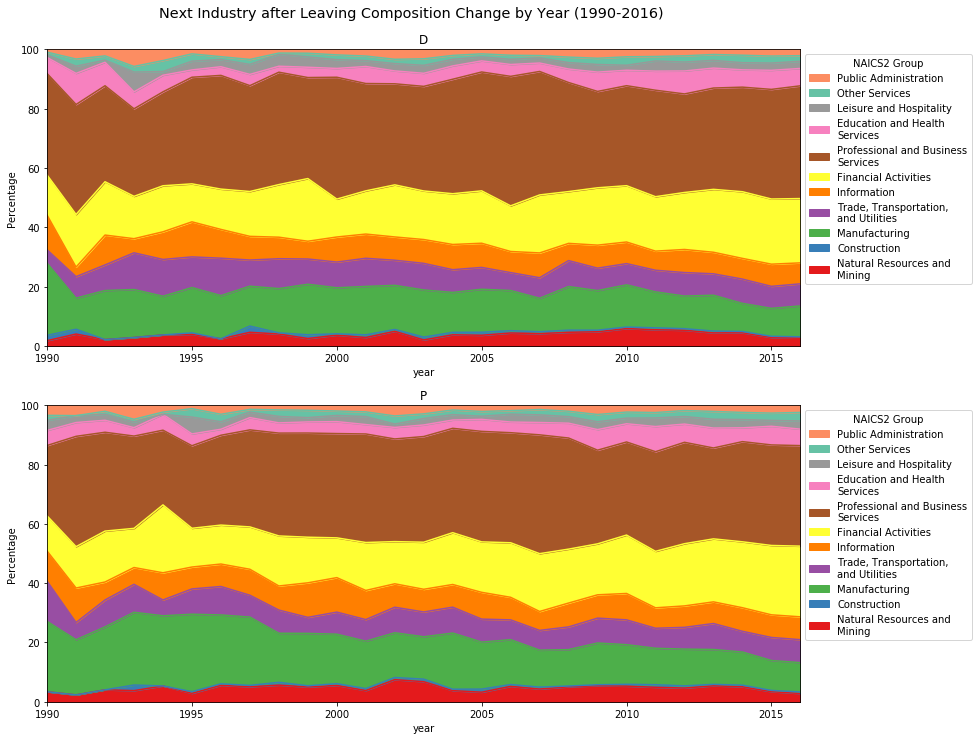

In [26]:
ind_next_lst = sorted(list(set(NAICS2GRP_dict.values())))
colormap_unif = {idx:clr for idx, clr in zip(
    ind_next_lst[:-1], # Assume the last element is "Others".
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif[ind_next_lst[-1]] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(1,2,figsize=(15,7.5))
# for (idx,col),ax in zip(empl_changes_df.loc[lambda df:df.type=='leaving'].pivot_table(
#     index=empl_changes_df.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
#     columns='ticker', values='gender', aggfunc='count'
# ).iteritems(),axs):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[x[1] for x in col.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(2,1,figsize=(13.5,12))
fig.suptitle("Next Industry after Leaving Composition Change by Year (1990-2016)", fontsize='x-large', y=0.93)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(df.type=='leaving'), ['ticker','type','year','ind_next']
    ].groupby('ticker'), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        columns=grp.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
        index='year', values='count', aggfunc='sum', fill_value=0
    )
    if f_none_hidden:
        to_plot.drop(ind_next_lst[-1], axis=1, inplace=True)
    to_plot = to_plot.apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=idx
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["\n".join(wrap(re.match(r"\(\d+, (.+)\)",x).group(1),25)) for x in reversed(labels)], 
        loc='upper left', bbox_to_anchor=(1,1), title="NAICS2 Group"
    )
plt.show()

## Tenure and Number of Promotions.

Note:
- Tenure = End date of last entry - Start date of first entry in a consecutive sequence of entries in the same company;
 - When there is any invalid month in the two dates and their years are _not_ the same, the invalid month is replaced by 6;
 - When there is any invalid month in the two dates and their years are the same, the invalid month is assumed to be the extreme value (0 for start and 12 for end) and the results are the minimum of their difference and 6.
- Number of promotions = Number of entries in a consecutive sequence of entries in the same company - 1.

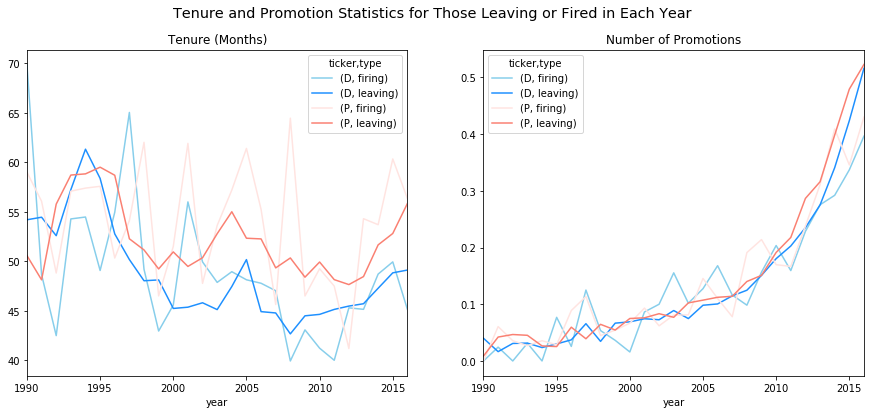

In [27]:
# Calculate.
to_plot = empl_changes_df.loc[lambda df:(df.type!='hiring')&(df.year>=1990)&(df.year<=2016)].astype(
    {'tenure':'Int64','nprom':'Int64'}
).pivot_table(
    columns=['ticker','type'],index='year',values=['tenure','nprom'],aggfunc=np.nanmean
)

# Plot.
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
fig.suptitle("Tenure and Promotion Statistics for Those Leaving or Fired in Each Year",fontsize='x-large')
to_plot['tenure'].plot(
    title="Tenure (Months)", color=[color_styles[0],color_styles[2],color_styles[3],color_styles[5]],ax=ax1
)
to_plot['nprom'].plot(
    title="Number of Promotions", color=[color_styles[0],color_styles[2],color_styles[3],color_styles[5]],ax=ax2
)
plt.show()